In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.fftpack
from scipy import signal
import scipy.io.wavfile
import copy
from scipy import optimize
import cv2
# %matplotlib inline
from scipy import ndimage, misc
from scipy.signal import butter, lfilter
from matplotlib.pyplot import loglog
import mmcv, cv2
from scipy.fft import fft, ifft
import math
from scipy import signal


/home/boston/anaconda3/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
def rgb_mean(ROI,number_of_skin_pixels):
    r = np.sum(ROI[:, :, 2]) / number_of_skin_pixels
    g = np.sum(ROI[:, :, 1]) / number_of_skin_pixels
    b = np.sum(ROI[:, :, 0]) / number_of_skin_pixels

    return r,g,b

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def normalize_complex_arr(a):
    a_oo = a - a.real.min() - 1j*a.imag.min() # origin offsetted
    return a_oo/np.abs(a_oo).max()

def get_signal_from_frames(pixel_list, frames):
    signal=[]
    for frame in frames:
        signal.append(frame[pixel_list[0],pixel_list[1]])
    return np.array(signal)

def blur_frames(frames, kernel=(5,5)):
    output=[]
    for frame in frames:
        output.append(cv2.blur(frame, kernel))
    return output

def sig_detrend(sig, method, time):
    if method=="constant":
         return signal.detrend(sig,type="constant")
    elif method=="linear":
         return signal.detrend(sig,type="linear")
    elif method=="polymonial":
        lin = lambda x, a, b : a * x + b 
        coeff, _ = optimize.curve_fit(lin,time, sig)
        sig= sig-( coeff[0] * time + coeff[1])
        return sig
    else:
        return sig

def bandpass(sig, method,lowcut,highcut, Fs, order):
    if method=="butter":
        return butter_bandpass_filter(sig, lowcut, highcut, Fs, order=order)   
    
    else:
        return sig
    
    
def preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order):
    detrended_signal=sig_detrend(sig,detrend_method,time)
    bandpassed_signal=bandpass(detrended_signal, bandpass_method,lowcut,highcut, Fs, order)
    
    return bandpassed_signal
  
def get_snr(sig,fouer_x):
    f=fft(sig)
    fourier=2.0/N * np.abs(f[0:N//2])
    Fheart_index=np.argmax(fourier)
    
    signal_bins=[Fheart_index-1, Fheart_index, Fheart_index+1, Fheart_index*2-1, Fheart_index*2, Fheart_index*2+1 ]

    max_bin=np.where(fouer_x >= 6)[0][0]
    min_bin=np.where(fouer_x <= 0.5)[0][-1]


    noise_bins=np.arange(min_bin,max_bin)
    noise_bins=noise_bins[~np.isin(noise_bins,signal_bins)]
    noise_values=fourier[noise_bins]
    noise_values=[val**2 for val in noise_values]


    signal_values=fourier[signal_bins]
    signal_values=[val**2 for val in signal_values]

    snr=10*math.log10(sum(signal_values)/sum(noise_values))

    return snr

In [3]:
def get_pos_signal_for_pixel(pixel,ROI_frames ):
    window_size=46


    rgb = np.empty((0, 3))
    for i, frame in enumerate(ROI_frames):
        r=frame[pixel[0],pixel[1],0]
        g=frame[pixel[0],pixel[1],1]
        b=frame[pixel[0],pixel[1],2]
        rgb = np.append(rgb, np.array([[r, g, b]]), axis=0)

    pos_signal = np.zeros(mean_rgb.shape[0])

    for window_start in range(0, (rgb.shape[0] - window_size)):
        window_mean_rgb = rgb[window_start:window_start + window_size - 1, :].T
        projection_matrix = np.array([[0, 1, -1], [-2, 1, 1]])
        POS = np.matmul(projection_matrix, window_mean_rgb)
        std = np.array([1, np.std(POS[0, :]) / np.std(POS[1, :])])
        pulse = np.matmul(std, POS)
        pos_signal[window_start:window_start + window_size - 1] = pos_signal[
                                                                                window_start:window_start + window_size - 1] + (
                                                                                        pulse - np.mean(pulse)) / np.std(
                        pulse)
        return pos_signal

## LOAD VIDEO

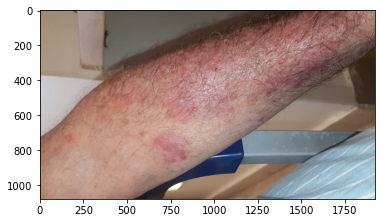

In [4]:
video = mmcv.VideoReader('psoriasis1.mp4')
raw_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in video]
raw_frames=raw_frames[:250]
plt.imshow(raw_frames[3])

In [5]:
N=len(raw_frames)
T=1/video.fps
Fs=video.fps
time=np.arange(0,N)/Fs
fouer_x=np.linspace(0.0, 1.0/(2.0*T), N//2)

detrend_method="constant"
bandpass_method="butter"
lowcut = 0.5
highcut=6
order=5
blur=False
blur_kernel=(150,150)
heart_beat=1

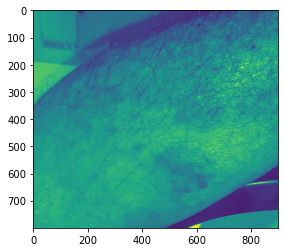

In [6]:
mean_rgb = np.empty((0, 3))
ROI_frames=[]
for frame in raw_frames:
    ROI=frame[200:1000,200:1100]
    ROI_frames.append(ROI)
    r,g,b=rgb_mean(ROI, ROI.shape[0]*ROI.shape[1])
    mean_rgb = np.append(mean_rgb, np.array([[r, g, b]]), axis=0)

green=[frame[:,:,1] for frame in ROI_frames]

if blur:
    frames=blur_frames(green,blur_kernel)
else:
    frames=green
    
plt.imshow(frames[3])

In [7]:
g=get_pos_signal_for_pixel((0,0), ROI_frames)

<ipython-input-3-4dbf2e84537d>:21: RuntimeWarning: invalid value encountered in true_divide
  window_start:window_start + window_size - 1] + (


In [8]:
len(g)

245

In [9]:
detrended_signal=sig_detrend(sig,detrend_method,time)
# plt.plot(detrended_signal)

nfreq = 6/(0.5*30)

n =  35
a = signal.firwin(n, cutoff = 3, window = 'blackmanharris')

firstpass = scipy.signal.lfilter(a, 1,detrended_signal)
plt.plot(firstpass)
plt.show()

f=fft(firstpass)
plt.plot(fouer_x, 2.0/N * np.abs(f[0:N//2]))
plt.title('proccessed signal fourier')
plt.xlim()

plt.show()

NameError: name 'sig' is not defined

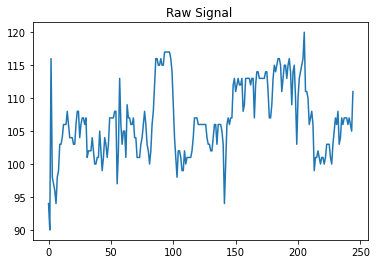

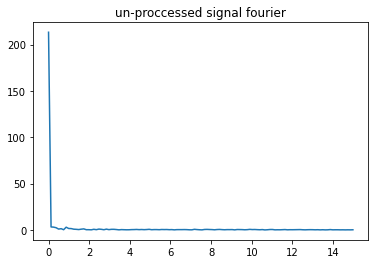

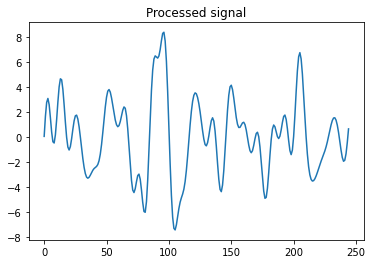

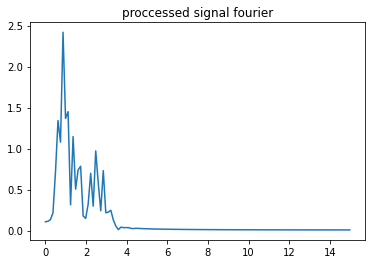

In [11]:
show_for="pixel"
example_pixel=[300,50]
detrend_method="linear"
bandpass_method="butter"
lowcut = 0.5
highcut=3
order=5

if show_for=="pixel":
    sig=get_signal_from_frames(example_pixel,frames)
else:
    sig=mean_rgb[:,1]

plt.plot(sig)
plt.title('Raw Signal ')

plt.show()

f=fft(sig)
plt.plot(fouer_x, 2.0/N * np.abs(f[0:N//2]))
plt.title('un-proccessed signal fourier')
plt.xlim()
plt.show()

proc_sig=preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )
plt.plot(proc_sig)
# plt.title(f'{detrend_method} detrend {bandpass_method} bandpass' )
plt.title('Processed signal')
plt.show()

f=fft(proc_sig)
plt.plot(fouer_x, 2.0/N * np.abs(f[0:N//2]))
plt.title('proccessed signal fourier')
plt.xlim()
plt.show()

## PIXEL SNR

In [21]:
example_pixel=[5,5]
detrend_method="constant"
bandpass_method="butter"
lowcut = 0.5
highcut=6
order=5

sig=get_signal_from_frames(example_pixel,frames)
proc_sig=preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )
snr=get_snr(proc_sig, fouer_x)


In [22]:
image.shape

(600, 750)

In [48]:
image=np.zeros([frames[3].shape[0],frames[3].shape[1]])
for x in range(image.shape[0]):
    for y in range(image.shape[1]):
        sig=get_signal_from_frames([x,y],frames)
        proc_sig=preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )
        snr=get_snr(proc_sig, fouer_x)
        image[x,y]=snr
        if ((x%100==0)&(y%100==0)):
            print (f'{x} and {y}')
        

<ipython-input-38-4dbf2e84537d>:21: RuntimeWarning: invalid value encountered in true_divide
  window_start:window_start + window_size - 1] + (
<ipython-input-38-4dbf2e84537d>:18: RuntimeWarning: invalid value encountered in double_scalars
  std = np.array([1, np.std(POS[0, :]) / np.std(POS[1, :])])


0 and 0
0 and 100
0 and 200
0 and 300
0 and 400
0 and 500
0 and 600
0 and 700
0 and 800
100 and 0
100 and 100
100 and 200
100 and 300
100 and 400
100 and 500
100 and 600
100 and 700
100 and 800
200 and 0
200 and 100
200 and 200
200 and 300
200 and 400
200 and 500
200 and 600
200 and 700
200 and 800
300 and 0
300 and 100
300 and 200
300 and 300
300 and 400
300 and 500
300 and 600
300 and 700
300 and 800
400 and 0
400 and 100
400 and 200
400 and 300
400 and 400
400 and 500
400 and 600
400 and 700
400 and 800
500 and 0
500 and 100
500 and 200
500 and 300
500 and 400
500 and 500
500 and 600
500 and 700
500 and 800
600 and 0
600 and 100
600 and 200
600 and 300
600 and 400
600 and 500
600 and 600
600 and 700
600 and 800
700 and 0
700 and 100
700 and 200
700 and 300
700 and 400
700 and 500
700 and 600
700 and 700
700 and 800


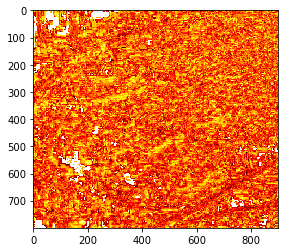

In [50]:
plt.imshow(image,cmap='hot', interpolation='nearest')

In [51]:


def get_amplitude(heart_beat, sig):
    w = 5
    widths = w * 30 / (2 * heart_beat * np.pi)

    cwtm = signal.cwt(sig, signal.morlet2, [widths], w=w)

    heart_beat_amp=sum(np.abs(cwtm[0]))

    return heart_beat_amp

In [52]:
image=np.zeros([frames[3].shape[0],frames[3].shape[1]])
for x in range(image.shape[0]):
    for y in range(image.shape[1]):
        sig=get_signal_from_frames([x,y],frames)
        proc_sig=preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )
        amp=get_amplitude(1.2,proc_sig)
        image[x,y]=amp
        if ((x%100==0)&(y%100==0)):
            print (f'{x} and {y}')
        

0 and 0
0 and 100
0 and 200
0 and 300
0 and 400
0 and 500
0 and 600
0 and 700
0 and 800
100 and 0
100 and 100
100 and 200
100 and 300
100 and 400
100 and 500
100 and 600
100 and 700
100 and 800
200 and 0
200 and 100
200 and 200
200 and 300
200 and 400
200 and 500
200 and 600
200 and 700
200 and 800
300 and 0
300 and 100
300 and 200
300 and 300
300 and 400
300 and 500
300 and 600
300 and 700
300 and 800
400 and 0
400 and 100
400 and 200
400 and 300
400 and 400
400 and 500
400 and 600
400 and 700
400 and 800
500 and 0
500 and 100
500 and 200
500 and 300
500 and 400
500 and 500
500 and 600
500 and 700
500 and 800
600 and 0
600 and 100
600 and 200
600 and 300
600 and 400
600 and 500
600 and 600
600 and 700
600 and 800
700 and 0
700 and 100
700 and 200
700 and 300
700 and 400
700 and 500
700 and 600
700 and 700
700 and 800


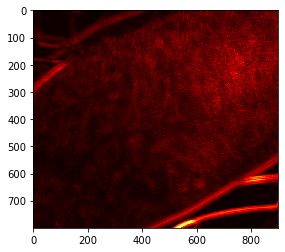

In [53]:
plt.imshow(image,cmap='hot', interpolation='nearest')

## CREATE AMP IMAGE

In [503]:
example_pixel=[450,450]
detrend_method="linear"
bandpass_method="butter"
lowcut = 0.5
highcut=6
order=5

sig=get_signal_from_frames(example_pixel,frames)
proc_sig=preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )


In [504]:
def get_amp(sig,fouer_x):
    
    
    f=fft(sig)
    fourier=2.0/N * np.abs(f[0:N//2])
    Fheart=fouer_x[np.argmax(fourier)]
    
    plt.plot(fouer_x,fourier)
    
#     signal_bins=[Fheart_index-1, Fheart_index, Fheart_index+1, Fheart_index*2-1, Fheart_index*2, Fheart_index*2+1 ]

#     max_bin=np.where(fouer_x >= 6)[0][0]
#     min_bin=np.where(fouer_x <= 0.5)[0][-1]


#     noise_bins=np.arange(min_bin,max_bin)
#     noise_bins=noise_bins[~np.isin(noise_bins,signal_bins)]
#     noise_values=fourier[noise_bins]
#     noise_values=[val**2 for val in noise_values]


#     signal_values=fourier[signal_bins]
#     signal_values=[val**2 for val in signal_values]

#     snr=10*math.log10(sum(signal_values)/sum(noise_values))

    return Fheart

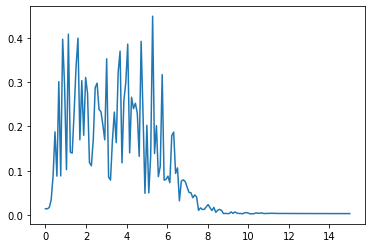

In [506]:
amp=get_amp(proc_sig,fouer_x)

In [502]:
amp*60

0.0

## REFERNCE 

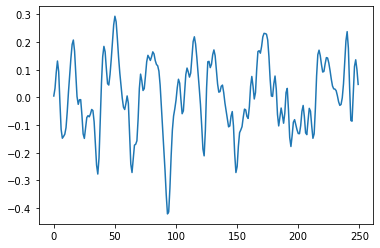

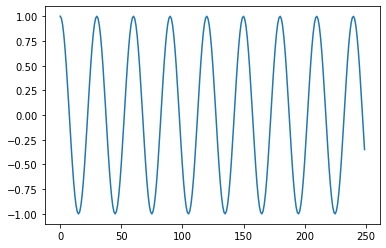

In [519]:
length=N/Fs
n=np.arange(0,length,1/Fs)
y=np.exp(2*1j*np.pi*heart_beat*n)
plt.plot(proc_sig)
plt.show()

plt.plot(y.real)
plt.show()


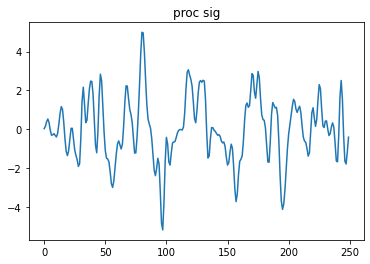

/home/boston/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


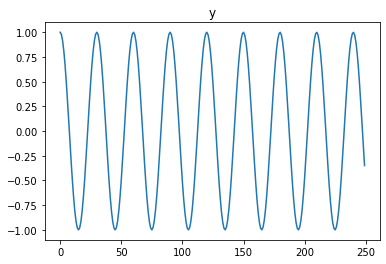

/home/boston/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


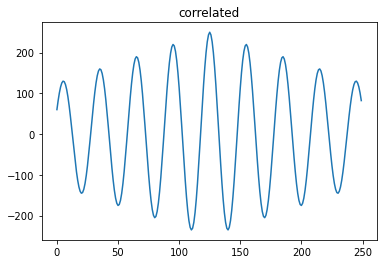

In [537]:
z=np.exp(2*1j*np.pi*heart_beat*n)



mul=np.multiply(y,proc_sig)
corr = signal.correlate(z, y, mode='same')

plt.plot(proc_sig)
plt.title ('proc sig')
plt.show()
plt.plot(y)
plt.title ('y')
# plt.show()
# plt.plot(mul.real)
# plt.title ('multiplied')
plt.show()
plt.plot(corr)
plt.title ('correlated')
plt.show()



## amplitude

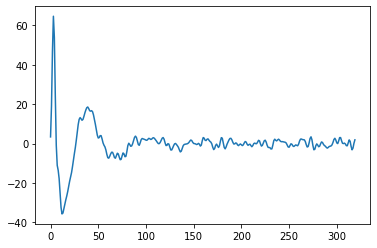

/home/boston/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


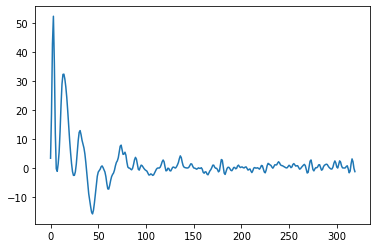

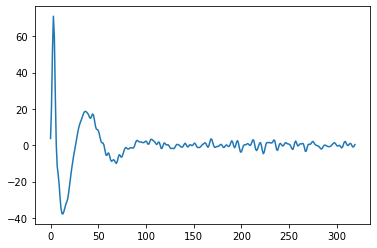

/home/boston/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


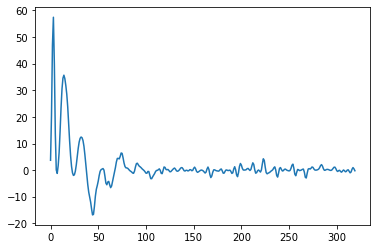

In [474]:
green_sig=[frame[270,600] for frame in green]
g_sig=np.array(green_sig)
g_sig = butter_bandpass_filter(g_sig, lowcut, highcut, Fs, order=4)

plt.plot(g_sig)
plt.show()

muli=np.multiply(g_sig,y)
plt.plot(muli)
plt.show()

green_sig=[frame[400,400] for frame in green]
g_sig=np.array(green_sig)
g_sig = butter_bandpass_filter(g_sig, lowcut, highcut, Fs, order=4)

plt.plot(g_sig)
plt.show()

muli=np.multiply(g_sig,y)
plt.plot(muli)
plt.show()

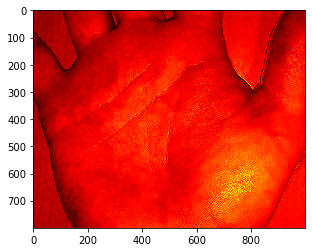

In [475]:
heatmap=[None]*len(green)
for i, frame in enumerate(green):
    heatmap[i]=frame*y[i]

maps=sum(heatmap)
a=np.abs(maps)
plt.imshow(a,cmap='hot', interpolation='nearest')

## SNR

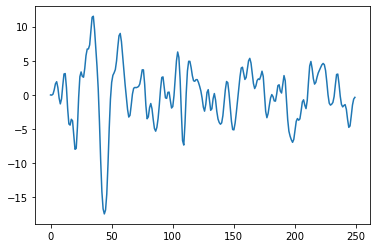

In [303]:
example_pixel=[300,300]
sig=get_signal_from_frames(example_pixel,frames)
sig=mean_rgb[:,1]
plt.plot(proc_sig)

In [304]:
def get_snr(sig,fouer_x):
    f=fft(sig)
    fourier=2.0/N * np.abs(f[0:N//2])
    Fheart_index=np.argmax(fourier)
    
    signal_bins=[Fheart_index-1, Fheart_index, Fheart_index+1, Fheart_index*2-1, Fheart_index*2, Fheart_index*2+1 ]

    max_bin=np.where(fouer_x >= 6)[0][0]
    min_bin=np.where(fouer_x <= 0.5)[0][-1]


    noise_bins=np.arange(min_bin,max_bin)
    noise_bins=noise_bins[~np.isin(noise_bins,signal_bins)]
    noise_values=fourier[noise_bins]
    noise_values=[val**2 for val in noise_values]


    signal_values=fourier[signal_bins]
    signal_values=[val**2 for val in signal_values]

    snr=10*math.log10(sum(signal_values)/sum(noise_values))

    return snr

In [305]:
get_snr(sig, fouer_x)

68.3502732894744

ValueError: x and y must have same first dimension, but have shapes (125,) and (75,)

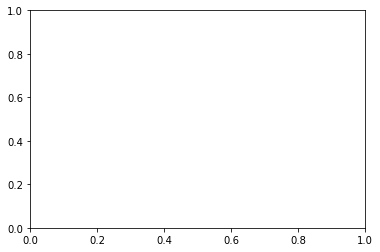

In [268]:
plt.plot(fouer_x,get_snr(proc_sig, fouer_x))   

In [254]:
fouer_x*60

array([  0.        ,   7.25370118,  14.50740236,  21.76110354,
        29.01480471,  36.26850589,  43.52220707,  50.77590825,
        58.02960943,  65.28331061,  72.53701179,  79.79071297,
        87.04441414,  94.29811532, 101.5518165 , 108.80551768,
       116.05921886, 123.31292004, 130.56662122, 137.82032239,
       145.07402357, 152.32772475, 159.58142593, 166.83512711,
       174.08882829, 181.34252947, 188.59623064, 195.84993182,
       203.103633  , 210.35733418, 217.61103536, 224.86473654,
       232.11843772, 239.3721389 , 246.62584007, 253.87954125,
       261.13324243, 268.38694361, 275.64064479, 282.89434597,
       290.14804715, 297.40174832, 304.6554495 , 311.90915068,
       319.16285186, 326.41655304, 333.67025422, 340.9239554 ,
       348.17765657, 355.43135775, 362.68505893, 369.93876011,
       377.19246129, 384.44616247, 391.69986365, 398.95356483,
       406.207266  , 413.46096718, 420.71466836, 427.96836954,
       435.22207072, 442.4757719 , 449.72947308, 456.98

## Animation

In [79]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)

ValueError: arrays must all be same length

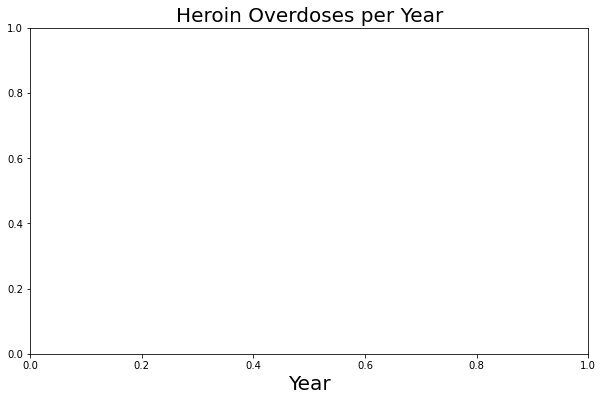

In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(figsize=(10,6))
plt.xlabel('Year',fontsize=20)
plt.title('Heroin Overdoses per Year',fontsize=20)

def animate(i):
    signush=proc_sig[:i]
    timush=time[:i]
    p = sns.lineplot(x=timush,y=signush, color="r")
    p.tick_params(labelsize=17)
    plt.setp(p.lines,linewidth=7)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(sig), repeat=True)   

ani.save('HeroinOverdosesJumpy.mp4', writer=writer)


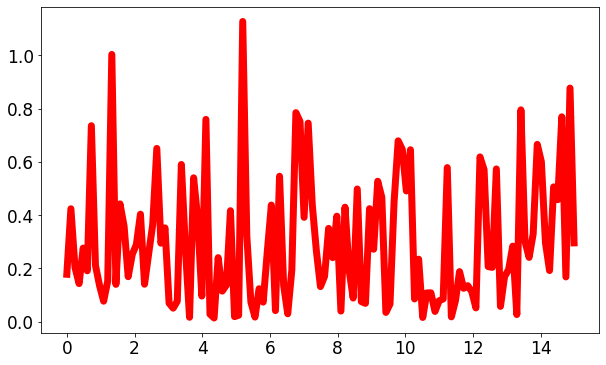

In [119]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(figsize=(10,6))

plt.xlabel('Year',fontsize=20)
plt.title('Heroin Overdoses per Year',fontsize=20)

def animate(i):
    fig.clear()
    noise = np.random.normal(0,50/(i+1),len(f))

    f_sig=fft(proc_sig)+noise
#     plt.plot(fouer_x, 2.0/N * np.abs(f_sig[0:N//2]))

    p = sns.lineplot(x=fouer_x,y=2.0/N * np.abs(f_sig[0:N//2]), color="r")
    p.tick_params(labelsize=17)
    plt.setp(p.lines,linewidth=7)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(sig), repeat=True)   

ani.save('HeroinOverdosesJumpy.mp4', writer=writer)

In [93]:
f=fft(proc_sig)
plt.plot(fouer_x, 2.0/N * np.abs(f[0:N//2]))
plt.title('proccessed signal fourier')
plt.xlim()
plt.show()

250